In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [11]:
x = mydata = (np.random.beta(0.5, 0.5, 10000)-0.5)

(array([2061.,  882.,  778.,  666.,  661.,  629.,  653.,  750.,  841.,
        2079.]),
 array([-4.99999987e-01, -3.99999989e-01, -2.99999990e-01, -1.99999992e-01,
        -9.99999932e-02,  5.33113942e-09,  1.00000004e-01,  2.00000002e-01,
         3.00000001e-01,  4.00000000e-01,  4.99999998e-01]),
 <a list of 10 Patch objects>)

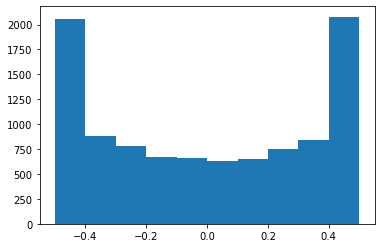

In [12]:
    plt.hist(x)



In [5]:
import keras
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
import tensorflow as tf

In [6]:
def myloss(y_true, y_pred, alpha = 0.01):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - alpha*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,0])) \
                - alpha*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,0]))
    return myoutput
    

In [7]:
#setup the model

myinput = Input(shape=(1,))
encoded = Dense(5, activation='elu')(myinput)
encoded = Dense(5, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

#First, pretrain the autoencoder:
#autoencoder.compile(optimizer='adam', loss='mse')
#autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

preds = []
preds += [encoder.predict(np.linspace(-4,4,10))]

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=1, batch_size=int(0.01*len(x)))

    y_scores = encoder.predict(np.concatenate([x,encoded_x]))
    print(i,roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]),y_scores))
    
    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=1, batch_size=int(0.01*len(x)))
    
    preds += [encoder.predict(np.linspace(-4,4,10))]
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True
        

on i= 0
200/200 [==============================] - 0s 669us/step - loss: 0.6831
0 0.50140819
100/100 [==============================] - 0s 822us/step - loss: -0.1424
on i= 1
200/200 [==============================] - 0s 676us/step - loss: 0.7019
1 0.498976625
100/100 [==============================] - 0s 831us/step - loss: -0.1535
on i= 2
200/200 [==============================] - 0s 674us/step - loss: 0.6943
2 0.5014714849999999
100/100 [==============================] - 0s 937us/step - loss: -0.1535
on i= 3
200/200 [==============================] - 0s 695us/step - loss: 0.6941
3 0.498827025
100/100 [==============================] - 0s 851us/step - loss: -0.1535
on i= 4
200/200 [==============================] - 0s 670us/step - loss: 0.6935
4 0.50258275
100/100 [==============================] - 0s 861us/step - loss: -0.1535
on i= 5
200/200 [==============================] - 0s 782us/step - loss: 0.6934
5 0.50112601
100/100 [==============================] - 0s 835us/step - loss: -0

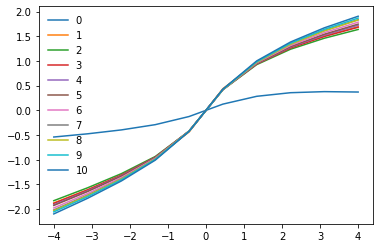

In [8]:
    for i in range(len(preds)):
        plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
        pass
    plt.legend(frameon=False)


In [9]:
mypreds = combinedModel_classifier.predict(x)

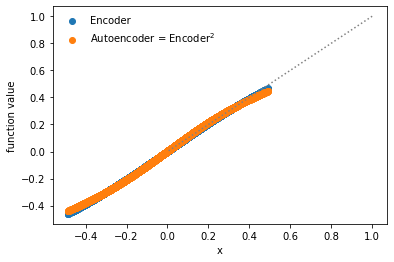

In [10]:
hi = 0
lo = 1
plt.scatter(x,mypreds[:,0],label="Encoder")
plt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")
plt.plot(np.linspace(lo,hi,10),np.linspace(lo,hi,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("function value")
plt.legend(frameon=False)